In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=1.5)
from tqdm import tqdm

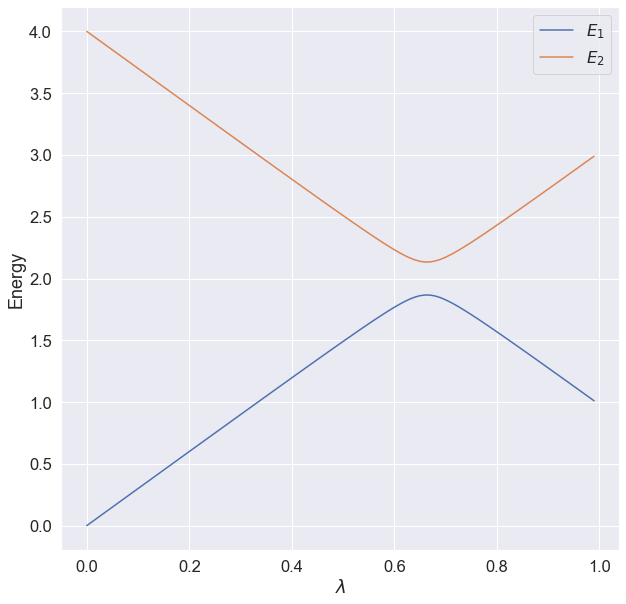

In [2]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

def Hamiltonian(lmb):
    E1 = 0
    E2 = 4
    V11 = 3
    V22 = -3
    V12 = 0.2
    V21 = 0.2

    eps = (E1 + E2) / 2
    omega = (E1 - E2) / 2
    c = (V11 + V22) / 2
    omega_z = (V11 - V22) / 2
    omega_x = V12

    H0 = eps * I + omega * sigma_z
    H1 = c * I + omega_z * sigma_z + omega_x * sigma_x
    return H0 + lmb * H1
    
lmbvalues_ana = np.arange(0, 1, 0.01)
eigvals_ana = np.zeros((len(lmbvalues_ana), 2))
for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(2):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'$E_{i+1}$')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()


In [3]:
from src.qc import *

def prepare_state(theta, phi, target = None):
    I = np.eye(2)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    state = np.array([1, 0])
    Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * sigma_x
    Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * sigma_y
    state = Ry @ Rx @ state
    if target is not None:
        state = target
    return state

def get_energy(angles, lmb, number_shots, target = None):
    theta, phi = angles[0], angles[1]
    # print(f'Theta = {theta}, Phi = {phi}')
    E1 = 0; E2 = 4; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2

    eps = (E1 + E2) / 2; omega = (E1 - E2) / 2; c = (V11 + V22) / 2; omega_z = (V11 - V22) / 2; omega_x = V12

    init_state = prepare_state(theta, phi, target)
    qubit = One_qubit()
    qubit.set_state(init_state)
    measure_z = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_hadamard()
    measure_x = qubit.measure(number_shots)
    
    # expected value of Z = (number of 0 measurements - number of 1 measurements)/ number of shots
    # number of 1 measurements = sum(measure_z)
    exp_val_z = (omega + lmb*omega_z)*(number_shots - 2*np.sum(measure_z)) / number_shots
    exp_val_x = lmb*omega_x*(number_shots - 2*np.sum(measure_x)) / number_shots
    exp_val_i = (eps + c*lmb) 
    exp_val = (exp_val_z + exp_val_x + exp_val_i)
    return exp_val #, (eps + c*lmb, omega + lmb*omega_z, lmb*omega_x), (measure_z, measure_x)

In [4]:
def minimize_energy(lmb, number_shots, angles_0, learning_rate, max_epochs):
    # angles = np.random.uniform(low = 0, high = np.pi, size = 2)
    angles = angles_0 #lmb*np.array([np.pi, np.pi])
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, lmb, number_shots)
    while (epoch < max_epochs) and (delta_energy > 1e-4):
        grad = np.zeros_like(angles)
        for idx in range(angles.shape[0]):
            angles_temp = angles.copy()
            angles_temp[idx] += np.pi/2 
            E_plus = get_energy(angles_temp, lmb, number_shots)
            angles_temp[idx] -= np.pi 
            E_minus = get_energy(angles_temp, lmb, number_shots)
            grad[idx] = (E_plus - E_minus)/2 
        angles -= learning_rate*grad 
        new_energy = get_energy(angles, lmb, number_shots)
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy

In [5]:
number_shots_search = 1000
number_shots = 1000
learning_rate = 1.0
max_epochs = 400
lmbvalues = np.linspace(0.0, 1.0, 30)
min_energy = np.zeros(len(lmbvalues))
epochs = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    memory = 0
    angles_0 = np.random.uniform(low = 0, high = np.pi, size = 2)
    angles, epochs[index], converged, energy, delta_energy = minimize_energy(lmb, number_shots_search, angles_0, learning_rate, max_epochs)
    if epochs[index] < (epochs[index-1] - 5):
        angles_0 = np.random.uniform(low = 0, high = np.pi, size = 2)
        angles, epochs[index], converged, energy, delta_energy = minimize_energy(lmb, number_shots_search, angles_0, learning_rate, max_epochs)
    min_energy[index] = get_energy(angles, lmb, number_shots)
    

100%|██████████| 30/30 [00:08<00:00,  3.55it/s]


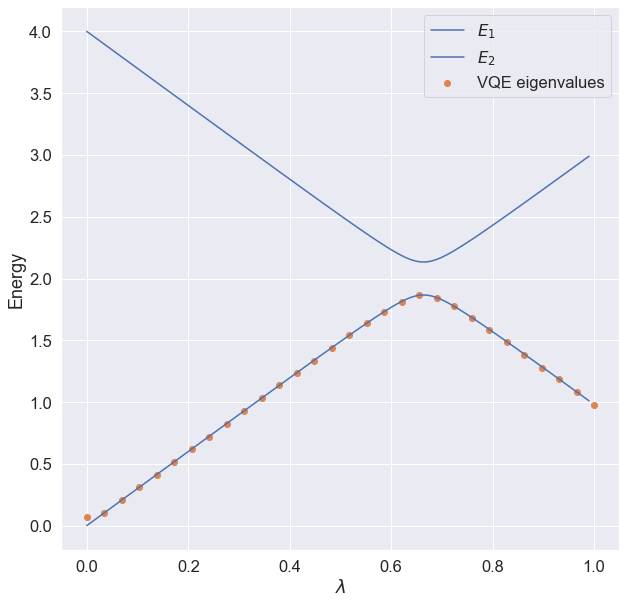

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(2):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'$E_{i+1}$', color = '#4c72b0')
axs.scatter(lmbvalues, min_energy, label = 'VQE eigenvalues', color = '#dd8452')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
plt.legend()
plt.show()



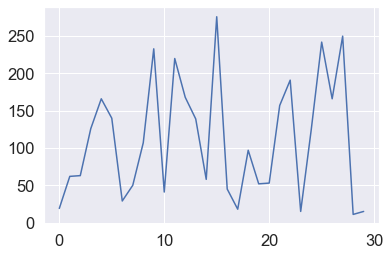

In [7]:
plt.plot(epochs)